In [1]:
import kagglehub
import os
import cv2
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch
from collections import defaultdict
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

In [2]:
path = kagglehub.dataset_download("tapakah68/facial-emotion-recognition")
print("Path to dataset:", path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

Using Colab cache for faster access to the 'facial-emotion-recognition' dataset.
Path to dataset: /kaggle/input/facial-emotion-recognition
cpu


In [3]:
def extract_and_resize_face(img, target_size=96):
    """Detect face on smaller version, crop from original, then resize"""

    # Step 1: Resize image for faster face detection
    h, w = img.shape[:2]
    detection_size = 640  # Process at this size for detection
    scale = detection_size / max(h, w)
    small_img = cv2.resize(img, None, fx=scale, fy=scale)

    # Step 2: Detect face on small image
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    gray_small = cv2.cvtColor(small_img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray_small, scaleFactor=1.1, minNeighbors=10, minSize=(30, 30))

    if len(faces) == 0:
        # Fallback: center crop if no face detected
        return smart_face_crop(img, target_size), False

    # Step 3: Scale face coordinates back to original image size
    x, y, w_face, h_face = max(faces, key=lambda f: f[2] * f[3])
    x = int(x / scale)
    y = int(y / scale)
    w_face = int(w_face / scale)
    h_face = int(h_face / scale)

    # Step 4: Add padding around face
    padding = int(max(w_face, h_face) * 0.3)
    x_start = max(0, x - padding)
    y_start = max(0, y - padding)
    x_end = min(w, x + w_face + padding)
    y_end = min(h, y + h_face + padding)

    # Step 5: Crop face from original image
    face_crop = img[y_start:y_end, x_start:x_end]

    # Step 6: Resize to target size
    face_resized = cv2.resize(face_crop, (target_size, target_size))

    return face_resized, True


def smart_face_crop(img, target_size=96):
    """
    Smart crop that biases toward upper portion for portrait images
    (where faces are usually located)
    """
    h, w = img.shape[:2]

    if h > w:
        # Portrait orientation - face is likely in upper portion
        crop_size = w  # Use width as crop size

        # Instead of centering vertically, bias toward top
        # Place crop so face (assumed to be in upper 40% of image) is centered in crop
        y_start = int(h * 0.15)  # Start at 15% from top

        # Make sure we don't go out of bounds
        if y_start + crop_size > h:
            y_start = h - crop_size

        x_start = 0  # Full width

    elif w > h:
        # Landscape orientation - face is likely in center horizontally
        crop_size = h  # Use height as crop size

        x_start = (w - crop_size) // 2  # Center horizontally
        y_start = 0  # Full height

    else:
        # Square image - just center crop
        crop_size = min(h, w)
        y_start = (h - crop_size) // 2
        x_start = (w - crop_size) // 2

    # Crop
    img_cropped = img[y_start:y_start+crop_size, x_start:x_start+crop_size]

    # Resize
    img_resized = cv2.resize(img_cropped, (target_size, target_size))

    return img_resized
# ============================================================
# STEP 1: Load data WITH person tracking + FACE DETECTION
# ============================================================

image_data_with_person = []
person_to_indices = defaultdict(list)

# Statistics tracking
total_files = 0
faces_detected = 0
center_cropped = 0

idx = 0
print("Loading images with face detection...")
print("="*60)

for root, dirs, files in os.walk(path):
    # Get person ID from folder name
    folder_name = os.path.basename(root)

    # Check if this is a person folder (should be a number)
    if not folder_name.isdigit():
        continue

    person_id = folder_name

    for file in files:
        if not file.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue

        total_files += 1
        file_path = os.path.join(root, file)
        img = cv2.imread(file_path)

        if img is None:
            print(f"❌ Failed to load: {file}")
            continue

        # Get emotion from filename
        emotion = os.path.splitext(file)[0]  # e.g., "Fear.jpg" -> "Fear"

        # FACE DETECTION + RESIZE
        img_resized, face_found = extract_and_resize_face(img, target_size=96)

        # Track statistics
        if face_found:
            faces_detected += 1
        else:
            center_cropped += 1

        # Convert to grayscale
        img_gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)

        # Store with person info
        image_data_with_person.append({
            'image': img_gray,
            'emotion': emotion,
            'person': person_id,
            'index': idx,
            'face_detected': face_found
        })

        person_to_indices[person_id].append(idx)
        idx += 1

        # Progress indicator
        if total_files % 20 == 0:
            print(f"Processed {total_files} images... (Faces: {faces_detected}, Crops: {center_cropped})")

print(f"\n{'='*60}")
print(f"Dataset loaded successfully with FACE DETECTION!")
print(f"{'='*60}")
print(f"Total images: {len(image_data_with_person)}")
print(f"✓ Faces detected: {faces_detected} ({faces_detected/len(image_data_with_person)*100:.1f}%)")
print(f"⚠ Center cropped (no face): {center_cropped} ({center_cropped/len(image_data_with_person)*100:.1f}%)")
print(f"Unique people: {len(person_to_indices)}")
print(f"\nImages per person:")
for person in sorted(person_to_indices.keys(), key=int):
    print(f"  Person {person}: {len(person_to_indices[person])} images")

# ============================================================
# STEP 2: Person-Independent Split
# ============================================================

people = list(person_to_indices.keys())
np.random.seed(42)  # For reproducibility
np.random.shuffle(people)

# 80/20 split of PEOPLE (not images!)
n_train_people = int(0.8 * len(people))
train_people = set(people[:n_train_people])
test_people = set(people[n_train_people:])

print(f"\n{'='*60}")
print(f"Person-Independent Split")
print(f"{'='*60}")
print(f"Train people ({len(train_people)}): {sorted(train_people, key=int)}")
print(f"Test people ({len(test_people)}): {sorted(test_people, key=int)}")

# ============================================================
# STEP 3: Create train/test datasets
# ============================================================

train_images = []
train_labels = []
test_images = []
test_labels = []

# Count face detection success in train/test
train_faces = 0
test_faces = 0

for item in image_data_with_person:
    if item['person'] in train_people:
        train_images.append(item['image'])
        train_labels.append(item['emotion'])
        if item['face_detected']:
            train_faces += 1
    else:
        test_images.append(item['image'])
        test_labels.append(item['emotion'])
        if item['face_detected']:
            test_faces += 1

# Fit label encoder on ALL emotions
le = LabelEncoder()
all_emotions = [item['emotion'] for item in image_data_with_person]
le.fit(all_emotions)

print(f"\nEmotion classes: {list(le.classes_)}")

# Encode labels
train_labels_encoded = le.transform(train_labels)
test_labels_encoded = le.transform(test_labels)

# Convert to numpy arrays and normalize
X_train = np.array(train_images, dtype=np.float32) / 255.0
X_train = X_train.reshape(-1, 1, 96, 96)

X_test = np.array(test_images, dtype=np.float32) / 255.0
X_test = X_test.reshape(-1, 1, 96,96)

print(f"\n{'='*60}")
print(f"Final Dataset Statistics")
print(f"{'='*60}")
print(f"Train set: {len(X_train)} images from {len(train_people)} people")
print(f"  ✓ Faces detected: {train_faces} ({train_faces/len(X_train)*100:.1f}%)")
print(f"Test set: {len(X_test)} images from {len(test_people)} people")
print(f"  ✓ Faces detected: {test_faces} ({test_faces/len(X_test)*100:.1f}%)")
print(f"Image shape: {X_train.shape}")

# ============================================================
# STEP 4: Create PyTorch datasets and loaders
# ============================================================

class FERDataset(Dataset):  #inherit from dataset  (facial emotion recognition)
    def __init__(self, images, labels,transform = None):
        """self.images = torch.tensor(images, dtype=torch.float32) """ #turn numpy array into pytorch tensor of float type for cnn
        self.images = images
        self.labels = torch.tensor(labels, dtype=torch.long) #turn labels into pytorch tensor of an integer
        self.transform = transform


    def __len__(self):
        return len(self.images) #simply the length of dataset which pytorch needs for batching

    def __getitem__(self, idx):
      image = self.images[idx]  # (96, 96) numpy array
      label = self.labels[idx]  #ensures the image-label tuples don't get mismatched


      # Convert to PIL Image for transforms
      image = (image * 255).astype(np.uint8)  # Convert back to 0-255
      image = transforms.ToPILImage()(image)

       # Apply augmentation
      if self.transform:
          image = self.transform(image)
      else:
          # No augmentation, just convert to tensor
          image = transforms.ToTensor()(image)

      return image, label


class Net(nn.Module): #A CNN is a NN
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        # Corrected the input size for fc1 based on calculations: 16 * 21 * 21 = 7056
        self.fc1 = nn.Linear(16 * 21 * 21, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8) # Changed output classes from 5 to 8
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) #These are logits
        return x

Loading images with face detection...
Processed 20 images... (Faces: 20, Crops: 0)
Processed 40 images... (Faces: 39, Crops: 1)
Processed 60 images... (Faces: 55, Crops: 5)
Processed 80 images... (Faces: 75, Crops: 5)
Processed 100 images... (Faces: 95, Crops: 5)
Processed 120 images... (Faces: 115, Crops: 5)
Processed 140 images... (Faces: 135, Crops: 5)

Dataset loaded successfully with FACE DETECTION!
Total images: 152
✓ Faces detected: 143 (94.1%)
⚠ Center cropped (no face): 9 (5.9%)
Unique people: 19

Images per person:
  Person 0: 8 images
  Person 1: 8 images
  Person 2: 8 images
  Person 3: 8 images
  Person 4: 8 images
  Person 5: 8 images
  Person 6: 8 images
  Person 7: 8 images
  Person 8: 8 images
  Person 9: 8 images
  Person 10: 8 images
  Person 11: 8 images
  Person 12: 8 images
  Person 13: 8 images
  Person 14: 8 images
  Person 15: 8 images
  Person 16: 8 images
  Person 17: 8 images
  Person 18: 8 images

Person-Independent Split
Train people (15): ['1', '2', '3', 

In [4]:
def create_augmented_dataset(images, labels, num_augmentations=5):
    """
    Create a dataset with pre-generated augmented copies

    Args:
        images: numpy array of original images (N, H, W)
        labels: numpy array of labels
        num_augmentations: how many augmented versions per image

    Returns:
        augmented_images, augmented_labels (both 10x larger)
    """

    # Define augmentation
    augment_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=20),
        transforms.RandomAffine(
            degrees=0,
            translate=(0.1, 0.1),
            scale=(0.8, 1.2),
        ),
    ])

    augmented_images = []
    augmented_labels = []

    print(f"Creating {num_augmentations} augmented versions of {len(images)} images...")

    # Keep originals
    augmented_images.extend(images)
    augmented_labels.extend(labels)

    # Generate augmented versions
    for i, (img, label) in enumerate(zip(images, labels)):
        if (i + 1) % 20 == 0:
            print(f"  Processing image {i+1}/{len(images)}...")

        for aug_num in range(num_augmentations):
            # Convert to PIL
            img_pil = Image.fromarray((img * 255).astype(np.uint8), mode='L')

            # Apply augmentation
            img_aug = augment_transform(img_pil)

            # Convert back to numpy
            img_aug_np = np.array(img_aug) / 255.0

            # Store
            augmented_images.append(img_aug_np)
            augmented_labels.append(label)

    augmented_images = np.array(augmented_images)
    augmented_labels = np.array(augmented_labels)

    print(f"\n✅ Done!")
    print(f"   Original: {len(images)} images")
    print(f"   Augmented: {len(augmented_images)} images ({len(augmented_images)/len(images):.0f}x)")

    return augmented_images, augmented_labels

# ============================================================
# USE IT
# ============================================================

# Create augmented dataset (10x larger)
X_train_augmented, y_train_augmented = create_augmented_dataset(
    X_train.squeeze(1),  # Remove channel dim
    train_labels_encoded,
    num_augmentations=5
)

# For TEST set - NO augmentation
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

X_test_2d = X_test.squeeze(1)
test_dataset = FERDataset(X_test_2d, test_labels_encoded, transform=test_transform)


print(f"\nNew dataset size: {len(X_train_augmented)} images")
print(f"Original: {len(X_train)} → Augmented: {len(X_train_augmented)}")

# Create dataset WITHOUT on-the-fly augmentation
train_dataset_large = FERDataset(
    X_train_augmented,
    y_train_augmented,
    transform=None  # No additional augmentation
)

# Create dataloader
train_loader_large = DataLoader(train_dataset_large, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


print(f"Batches per epoch: {len(train_loader_large)}")

Creating 5 augmented versions of 120 images...
  Processing image 20/120...
  Processing image 40/120...
  Processing image 60/120...
  Processing image 80/120...
  Processing image 100/120...
  Processing image 120/120...

✅ Done!
   Original: 120 images
   Augmented: 720 images (6x)

New dataset size: 720 images
Original: 120 → Augmented: 720
Batches per epoch: 45


/tmp/ipython-input-1417283314.py:41: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  img_pil = Image.fromarray((img * 255).astype(np.uint8), mode='L')


In [5]:


def train_with_early_stopping(net, epochs, train_loader, test_loader, criterion, optimizer,
                               device='cpu', patience=30, print_every=100):

    # Track metrics
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    batch_losses = []
    best_test_acc = 0
    patience_counter = 0

    for epoch in range(epochs):
        # ============ TRAINING ============
        net.train()
        total_loss = 0.0
        batch_loss_accum = 0.0

        print(f"\n{'='*60}")
        print(f"Epoch {epoch+1}/{epochs}")
        print(f"{'='*60}")

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_losses.append(loss.item())
            total_loss += loss.item()
            batch_loss_accum += loss.item()

            # Print batch progress
            if (batch_idx + 1) % print_every == 0 or (batch_idx + 1) == len(train_loader):
                avg_batch_loss = batch_loss_accum / min(print_every, batch_idx + 1)
                print(f"  Batch {batch_idx+1}/{len(train_loader)} | Loss: {avg_batch_loss:.4f}")
                batch_loss_accum = 0.0

        epoch_train_loss = total_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # ============ VALIDATION/TEST ============
        net.eval()
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = net(inputs)
                test_loss += criterion(outputs, labels).item()

                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        epoch_test_loss = test_loss / len(test_loader)
        test_losses.append(epoch_test_loss)

        test_acc = 100 * correct / total
        test_accuracies.append(test_acc)

        train_acc = evaluate_accuracy(net, train_loader)
        train_accuracies.append(train_acc)

        # ============ EPOCH SUMMARY ============
        print(f"\n📊 Epoch {epoch+1} Summary:")
        print(f"  Train Loss: {epoch_train_loss:.4f}")
        print(f"  Test Loss : {epoch_test_loss:.4f}")
        print(f"  Train Acc : {train_acc:.2f}%")
        print(f"  Test Acc  : {test_acc:.2f}%")

        # ============ EARLY STOPPING ============
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            patience_counter = 0
            torch.save(net.state_dict(), 'best_model.pth')
            print(f"  ✅ New best model saved! (Test Acc: {best_test_acc:.2f}%)")
        else:
            patience_counter += 1
            print(f"  ⏳ Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print(f"\n⚠️ Early stopping at epoch {epoch+1}")
            break

    # ============ LOAD BEST MODEL ============
    net.load_state_dict(torch.load('best_model.pth'))
    print(f"\n{'='*60}")
    print(f"✅ Training Complete!")
    print(f"✅ Best Test Accuracy: {best_test_acc:.2f}%")
    print(f"{'='*60}")

    return {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'batch_losses': batch_losses}


In [6]:
def evaluate_accuracy(net, dataloader, device='cpu'):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

In [7]:
net = Net().to(device)

crit = nn.CrossEntropyLoss()  #Built-in softmax!
opti = optim.Adam(net.parameters(), lr=0.003)

In [8]:
results = train_with_early_stopping(
    net=net,
    epochs=200,
    train_loader=train_loader_large,
    test_loader=test_loader,
    criterion=crit,
    optimizer=opti,
    patience= 30  # Stop if no improvement for 25 epochs
)


Epoch 1/200
  Batch 45/45 | Loss: 2.0850

📊 Epoch 1 Summary:
  Train Loss: 2.0850
  Test Loss : 2.0797
  Train Acc : 12.50%
  Test Acc  : 12.50%
  ✅ New best model saved! (Test Acc: 12.50%)

Epoch 2/200
  Batch 45/45 | Loss: 2.0818

📊 Epoch 2 Summary:
  Train Loss: 2.0818
  Test Loss : 2.0797
  Train Acc : 12.50%
  Test Acc  : 12.50%
  ⏳ Patience: 1/30

Epoch 3/200
  Batch 45/45 | Loss: 2.0814

📊 Epoch 3 Summary:
  Train Loss: 2.0814
  Test Loss : 2.0796
  Train Acc : 13.75%
  Test Acc  : 12.50%
  ⏳ Patience: 2/30

Epoch 4/200
  Batch 45/45 | Loss: 2.0813

📊 Epoch 4 Summary:
  Train Loss: 2.0813
  Test Loss : 2.0795
  Train Acc : 12.50%
  Test Acc  : 12.50%
  ⏳ Patience: 3/30

Epoch 5/200
  Batch 45/45 | Loss: 2.0816

📊 Epoch 5 Summary:
  Train Loss: 2.0816
  Test Loss : 2.0795
  Train Acc : 12.50%
  Test Acc  : 12.50%
  ⏳ Patience: 4/30

Epoch 6/200
  Batch 45/45 | Loss: 2.0811

📊 Epoch 6 Summary:
  Train Loss: 2.0811
  Test Loss : 2.0796
  Train Acc : 12.50%
  Test Acc  : 12.50%
  ⏳

In [9]:
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt

In [10]:
train_losses = results['train_losses']
test_losses = results['test_losses']
train_accuracies = results['train_accuracies']
test_accuracies = results['test_accuracies']
batch_losses = results['batch_losses']

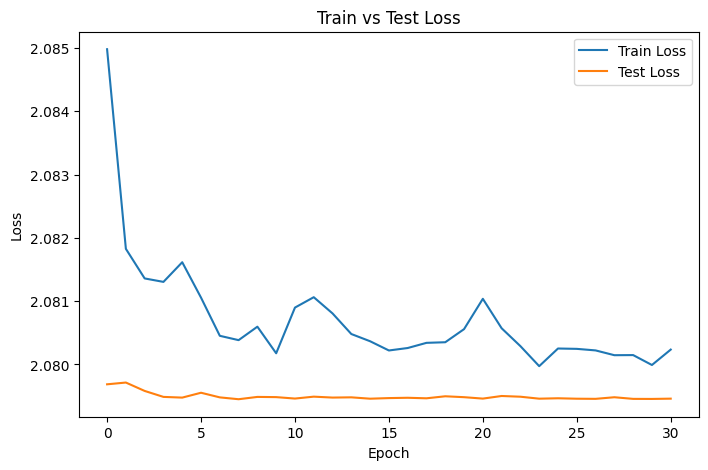

In [11]:
plt.figure(figsize=(8,5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Test Loss")
plt.legend()
plt.show()

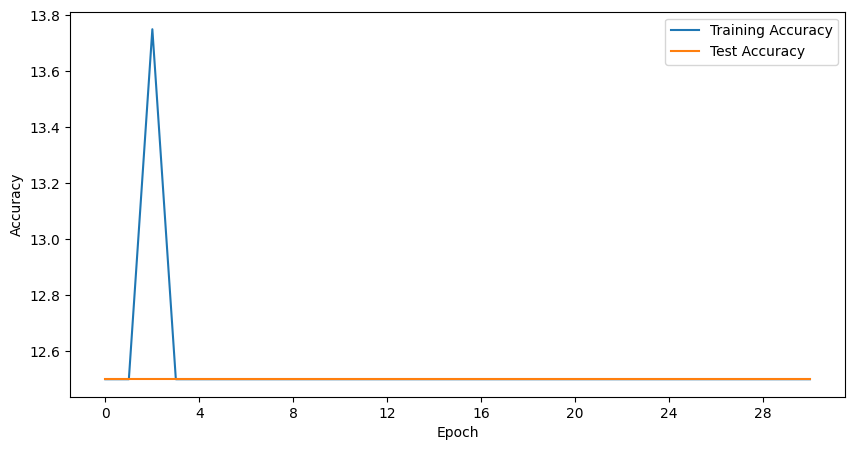

In [12]:
plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # make x axis integers
plt.show()